<a href="https://colab.research.google.com/github/philippe753/CNN_project/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Import libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import glob
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision 
from matplotlib import pyplot as plt
import gc
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, AveragePooling2D, Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import pickle
import time
import cv2

In [ ]:
# unzip the data frame containing the celebraties images
!unzip "/content/drive/MyDrive/AI_dataset/img_align_celeba.zip"

In [ ]:
  # Importing data
  data_Y = pd.read_excel("/content/drive/MyDrive/AI_dataset/list_attr_celeba.xlsx")
  data_Y_columns = data_Y.iloc[0] # This contains the name of the features/columns of the dataframe.

  # Inspecting Data

  # plot of the first 5 columns of the raw data
  print("Raw data frame: \n")
  print(data_Y.head(5))


  data_Y = data_Y.replace(-1, 0) # Replace -1 for a 0.
  # Deleating the first row, since it contains it just a interger refereing to the total number of imgs.
  first_row = data_Y.iloc[0] #grab the first row for the header
  data_Y = data_Y[1:] #take the data less the header row
  data_Y.columns = first_row #set the header row as the df header
  print('New data frame: \n')
  data_Y.head(5)

Raw data frame: 

       202599        Unnamed: 1  ...      Unnamed: 39 Unnamed: 40
0           #  5_o_Clock_Shadow  ...  Wearing_Necktie       Young
1  000001.jpg                -1  ...               -1           1
2  000002.jpg                -1  ...               -1           1
3  000003.jpg                -1  ...               -1           1
4  000004.jpg                -1  ...               -1           1

[5 rows x 41 columns]
New data frame: 



,#,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
1,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
2,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
4,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
5,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
# download dataframe y

#pickle_out =  open("X.pickle", "bw")
#pickle.dump(training_data, pickle_out)
#pickle_out.close()

In [2]:
# Load data frame y
data_Y = pickle.load(open("/content/drive/MyDrive/AI_dataset/y.pickle","rb"))
#data_X = pickle.load(open("X.pickle","rb"))

## Description of our data Frame
As we can see bellow, most examples are not bold, do not have Clock shadow, do not have bangs, do not have blond hair, do not have double chin, do not have eyeglasses, do not have a Goatee, nor gray_hair, nor mustache, nor male skin, nor have a recending hairline, nor have rosy cheeks,nor side burns, nor wearing a hat, nor wearing a necktie.

The first model we'll learn is a  simple logisitc neural network to try to predict attrative and non attrative people. 

In [ ]:
data_Y.describe()

,#,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599
unique,202599,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,093762.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
freq,1,180083,148509,103833,161153,198052,171890,153814,155083,154127,172616,192287,161027,173796,190936,193140,189406,189883,194100,124209,110410,118165,104657,194182,179270,169158,145032,193898,146389,186436,189284,191150,104930,160377,137855,164323,192781,106884,177686,187867,156734


## Randomly pick m images to be the training set.
Every image is flattened from a 3 dimmensional array to a 1-dimensional array and then standarized.

In [3]:
# randomly sample all the attractive people
data_Y_attractive = data_Y[data_Y["Attractive"] == 1]["Attractive"].sample(frac=1)
data_Y_attractive_idx = data_Y_attractive.index[0:]

data_Y_unattractive = data_Y[data_Y["Attractive"] == 0]["Attractive"].sample(frac=1)
#data_Y_unattractive = np.random.shuffle(data_Y_unattractive)
data_Y_unattractive_idx = data_Y_unattractive.index[0:]


In [5]:
data_Y_attractive_idx[0]

166201

In [4]:
# randomly sample all the attractive people
m_train = 1500
#m_test = 100
num_features = 116412
train_Y_attractive = data_Y_attractive.head(m_train)
#test_Y_attractive = data_Y_attractive.head(m_test)
attractive_idx = data_Y_attractive_idx[0:(m_train)] #+m_test
train_X_attractive = np.zeros((num_features, m_train))
#test_X_attractive = np.zeros((num_features, m_test))

# the same for the unattractive data set
train_Y_unattractive = data_Y_unattractive.head(m_train)
#test_Y_unattractive = data_Y_attractive.head(m_test)
unattractive_idx = data_Y_unattractive_idx[0:(m_train)]#+m_test
train_X_unattractive = np.zeros((num_features, m_train))
#test_X_unattractive = np.zeros((num_features, m_test))

img_path = np.sort(glob.glob("img_align_celeba/*.*"))

# randomly select samples from the attractive data set, and flatter it to an array
for i in range(0, m_train):
    img = cv2.imread(img_path[attractive_idx[i]])
    img_v = img.reshape((img.shape[0] * img.shape[1] * img.shape[2], 1))
    #if i < m_train:
        # for training set:
    train_X_attractive[:, i] = img_v[:, 0]
    #elif i>=m_train: 
    #    # for test set:
    #    test_X_attractive[:, (i-m_train)] = img_v[:, 0]

# randomly select samples from the unattractive data set, and flatter it to an array
for i in range(0, m_train):
    img = cv2.imread(img_path[unattractive_idx[i]])
    img_v = img.reshape((img.shape[0] * img.shape[1] * img.shape[2], 1))
    #if i < m_train: 
    train_X_unattractive[:, i] = img_v[:, 0]
    #elif i>=m_train:
    #    # for test set:
    #    test_X_unattractive[:, (i-m_train)] = img_v[:, 0]


In [5]:
X = np.concatenate((train_X_attractive, train_X_unattractive), axis=1)
X.shape
y = np.reshape(np.concatenate((train_Y_attractive, train_Y_unattractive)), (1, -1))
############ TO DO ##############3
# try to make the sets in cointain both the attractive and unattractive .

In [26]:
y = y
X = X
print("X_train shape is: " + str(X.shape))
print("y is: " + str(y.shape))

X_train shape is: (116412, 3000)
y is: (1, 3000)


In [28]:
X_train_f, X_test_f, y_train_f,  y_test_f = train_test_split(X,
                                                             y,
                                                             test_size=0.1,
                                                             random_state=42)

ValueError: ignored

In [25]:
print("X_train_f shape is: " + str(X_train_f.shape))
print("y_train_f is: " + str(y_train_f.shape))
print(y[1498:1505])

X_train_f shape is: (2700, 116412)
y_train_f is: (2700, 1)
[[1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


### Randomly picking data - part 2

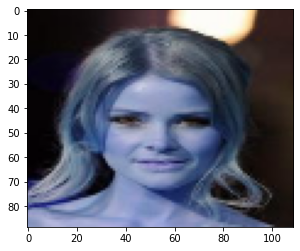

In [4]:
m =  2000 # number of examples to train the models
m_test = 200
num_features = 29103 #116412 # num of features for each image
train_X = np.zeros((num_features, m))
train_Y = pd.DataFrame(data=data_Y.columns, columns=data_Y.columns)
test_X = np.zeros((num_features, m_test))
test_Y = pd.DataFrame(data=data_Y.columns, columns=data_Y.columns)
# random numbers to selecet the training examples from the data frame.
rand_num = np.random.choice(range(202599), (m + m_test), replace=False) 
img_path = np.sort(glob.glob("img_align_celeba/*.*"))


for i in range(0, m + m_test):
    img = cv2.imread(img_path[i])
    # flat image into an array.
    img =  cv2.resize(img, (109, 89))
    if i <10:
      plt.imshow(img)

    img_v = img.reshape((img.shape[0] * img.shape[1] * img.shape[2], 1))
    if i < m:
        train_X[:, i] = img_v[:, 0]
        # find the equivalent samples in data_Y.
        train_Y = pd.concat([train_Y, data_Y[data_Y['#'] == data_Y.iloc[i][0]]], ignore_index=True)

    elif i>=m:
        # same as above but for the test set.
        test_X[:, (i-m)] = img_v[:, 0]
        test_Y = pd.concat([test_Y, data_Y[data_Y['#'] == data_Y.iloc[i][0]]], ignore_index=True)

# Standardize data
train_X = train_X / 255.0
test_X = test_X / 255.0

# For now, we are only interested on the attribute attractive.
train_Y_attractive = train_Y['Attractive']
train_Y_attractive = train_Y_attractive.values.reshape((1, -1))
test_Y_attractive = test_Y['Attractive']
test_Y_attractive = test_Y_attractive.values.reshape((1, -1))

In [7]:
## Visualizing the training set. 
# Note that since our models were randomly chosen from the data frame, then this
# sample should be a good representation of the Data Frame.
print("train_X shape is: " + str(train_X.shape))
print("train_Y_attractive shape is: " + str(train_Y_attractive.shape))
print("test_X shape is: " + str(test_X.shape))
print("test_Y_attractive shape is: " + str(test_Y_attractive.shape))


train_X shape is: (29103, 2000)
train_Y_attractive shape is: (1, 2000)
test_X shape is: (29103, 200)
test_Y_attractive shape is: (1, 200)


In [ ]:
# class weights to balance the training between all classes
#class_weights = []
#for i in range(train_df.size)):
#    class_weights.append(len(train_df) / (20 * train_df[labels].sum()[i]))
#class_weights_dict = {i: class_weights[i] for i in range(0, len(class_weights))}

## Perceptron model to predict attractive and non-attractive people.

We will implement the most basic implementation of a neural network to see how good a single layer neural network can accurately predict if a person is attractive or not. 

In [ ]:
class Perceptron:
      def __init__(self, learning_rate=0.01, num_ite=1000):
          self.learning_rate = learning_rate
          self.num_ite = num_ite

      def initialize_parameters(self, X):
          num_W = X.shape[0]
          W = np.random.randn(num_W, 1) * 0.01
          b = 0
          parameters = {"W": W, "b": b}
          return parameters

      def train(self, X, Y):
          params = self.initialize_parameters(X)
          for i in range(self.num_ite):
              print(i)
              W = params["W"]
              b = params["b"]
              print(W)
              print(b)
              A = self.forward_propagation(W, b, X)
              #print(A)
              cost = self.cost_function(A, Y)
              grads = self.backward_propagation(A, X, Y)
              params = self.update_rule(params, grads)      
          return params, grads, cost

      def forward_propagation(self, W, b, X):
          Z = np.dot(W.T, X) + b
          A = self.sigmoid_function(Z)
          return A
          
      def sigmoid_function(self, Z):
          Z = np.array(Z, dtype=np.float32)
          sig = 1/(1 + np.exp(-Z))
          return sig

      def cost_function(self, y_hat, Y):  
          m = y_hat.shape[1]  
          #print(y_hat)
          cost = (- 1 / m) * np.sum(Y * np.log(y_hat) + (1 - Y) * (np.log(1 - y_hat)))
          print('COST: ' + str(cost))
          return cost

      def backward_propagation(self, A, X, Y):
          dW = (1 / m) * np.dot(X, (A - Y).T)
          db = (1 / m) * np.sum(A - Y)
          grads = {"dW": dW, "db": db}
          return grads

      def update_rule(self, params, grads):
          dW = grads["dW"]
          db = grads["db"]
          W = params["W"]
          b = params["b"]
          W = W - self.learning_rate * dW
          b = b - self.learning_rate * db
          parameters = {"W": W, "b": b}
          return parameters
      
      def predict(self,params, test_X, test_Y):
        m = test_X.shape[1]
        A = self.forward_propagation(W, b, test_X)
        Y_prediction = np.where(A >0.5, 1, 0)
        return Y_prediction
          

In [ ]:

my_perceptron = Perceptron(learning_rate=0.01, num_ite=10)
params, grads, cost = my_perceptron.train(train_X, train_Y_attractive)
#parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [ ]:
fit(train_X, train_Y_):

In [44]:
train_X = train_X.T
train_Y_attractive = np.array(train_Y_attractive, dtype=np.float).T
test_X = test_X.T
test_Y_attractive = np.array(test_Y_attractive.T,, dtype=np.float).T

In [55]:
#test_X = test_X.T
#test_Y_attractive = test_Y_attractive.T
print(train_X.shape)
print(test_X.shape)
print(test_Y_attractive.shape)


(2000, 29103)
(200, 29103)
(200, 1)


In [80]:
# Perceptron using sklearn
max_iter = 40
eta0 = 0.1

ppn = Perceptron(max_iter=max_iter, 
                 eta0=eta0, 
                 random_state = 0)

ppn.fit(train_X, train_Y_attractive)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=40, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [94]:
test_Y_attractive = np.array(test_Y_attractive, dtype=np.float)

In [90]:
# Predict
y_pred = y_pred.astype(int)

In [ ]:
#print(type(y_pred))
#print(y_pred.size)
#print(type(test_Y_attractive))
y_pred[0:10]
test_Y_attractive[0:10]

In [96]:
# Accuracy of the test set
print("accuracy: {0:.2f}%",
      format(accuracy_score(test_Y_attractive,
                            y_pred)*100))

accuracy: {0:.2f}% 61.5


In [ ]:
# Implementing a deep neural network

class DeepNN:

    def __init__(self, learning_rate=0.01, num_ite=1000):
        self.learning_rate = learning_rate
        self.num_ite = num_ite

    def initialize_parameters_deep(self, layer_dims):
        parameters = {}
        L = len(layer_dims) # number of layers in the network
        for l in range(1, L):
            parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
            parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        return parameters

    def fit(self, X, Y, layers_dims):
        costs = []                        
        # Initialize parameters
        parameters = self.initialize_parameters_deep(layers_dims)
        for i in range(0, self.num_ite):
            print(i)
            # Forward propagation: with a relu and then sigmoid activation function
            AL, caches = self.L_model_forward(X, parameters)
            # Cost function
            cost  = self.compute_cost(AL, Y)
            # Initializing backward propagation
            grads = self.L_model_backward(AL, Y, caches)
            # Update the paramters.
            parameters = self.update_parameters(parameters, grads, self.learning_rate)

            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        return parameters, costs 

    def linear_forward(self, A, W, b):
        # Implement the linear part of a layer's forward propagation. ( CHANGE )
        Z = np.dot(W, A) + b
        cache = (A, W, b)  
        return Z, cache

    def L_model_forward(self, X, parameters):
        # Implement the linear part of a layer's forward propagation.
        caches = []
        A = X
        L = len(parameters) // 2 
        # loop every layer
        for l in range(1, L):
            A_prev = A 
            A, cache = self.linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
            caches.append(cache)
        AL, cache = self.linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
        caches.append(cache)
        return AL, caches

    def linear_backward(self, dZ, cache):
        # Implement the linear portion of backward propagation for a single layer ( CHANGE )
        A_prev, W, b = cache
        m = A_prev.shape[1]
        dW = (1./m) * np.dot(dZ, A_prev.T)
        db = (1./m) * np.sum(dZ, axis = 1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)        
        return dA_prev, dW, db

    def L_model_backward(self, AL, Y, caches):
        grads = {}
        L = len(caches) # the number of layers
        m = AL.shape[1]
        Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        current_cache = caches[L-1]
        dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(dAL, current_cache, "sigmoid")
        grads["dA" + str(L)] = dA_prev_temp
        grads["dW" + str(L)] = dW_temp
        grads["db" + str(L)] = db_temp
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
            grads["dA" + str(l + 1)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp
        return grads

    def linear_activation_forward(self, A_prev, W, b, activation):
        # Implement the forward propagation for the LINEAR->ACTIVATION layer
        Z, linear_cache = self.linear_forward(A_prev, W, b)
        Z = np.array(Z,dtype=np.float32)
        if activation == "sigmoid":
            A = 1/(1 + np.exp(-Z))
        elif activation == "relu":
            A = np.maximum(Z, 0)
        cache = (linear_cache, Z)  
        return A, cache

    def linear_activation_backward(self, dA, cache, activation):
        # Backward propagation.
        linear_cache, activation_cache = cache
        Z = activation_cache
        if activation == "relu":
          # Implement Back propagation witha relu activation function
            dsig = np.where(Z>0, 1, 0)
            dZ = dA * dsig
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
        elif activation == "sigmoid":
          # Implement Back propagation witha sigmoid activation function
            dsig = 1/(1+np.exp(-Z)) * (1 - 1/(1+np.exp(-Z)))
            dZ = dA * dsig    #= self.sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
        return dA_prev, dW, db

    def compute_cost(self, AL, Y):
        cost = -(1/m) * (np.dot(Y, np.log(AL).T) + np.dot((1 - Y), np.log(1-AL).T))
        cost = np.squeeze(cost)
        return cost

    def update_parameters(self, params, grads, learning_rate):
        # Update the weiths and bieses of each layer
        parameters = params.copy()
        L = len(parameters) // 2
        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        return parameters

    def prediction(self, test_X, test_Y, parameters):
        AL, caches = self.L_model_forward(test_X, parameters)
        y_hat = np.where(AL>=0.5, 1, 0)
        m = y_hat.shape[1]
        y_percentage = ( 1 - (1/m) * np.sum(abs(y_hat - test_Y)) ) * 100
        # The unit step activation function returns only 1 or 0.
        return y_hat, y_percentage

      

In [ ]:
layers_dims = [29103, 20, 7, 5, 1]
              
my_deepNN = DeepNN(learning_rate=0.0075, num_ite=2500)
parameters, costs = my_deepNN.fit(train_X, train_Y_attractive, layers_dims)
#parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

NameError: ignored

In [ ]:
y_hat, y_percentage = my_deepNN.prediction(test_X, test_Y_attractive, parameters)

In [ ]:
print(y_hat)
print(y_percentage)


In [ ]:
print(test_Y_attractive)
print(y_hat - test_Y_attractive)


In [ ]:
# Convolutional neural network
resnet = ResNet50(include_top=False, pooling='avg')
model = Sequential()
model.add(resnet)
model.add(Dense(1))
model.layers[0].trainable = False

_ = model(tf.zeros([1, 218,178, 3]))

model.summary()

## Logistic Regression

## Convolutional Nueral Networks

In [ ]:
y = data_Y['Attractive'].head(5000)
y.describe()

count     5000
unique       2
top          1
freq      2561
Name: Attractive, dtype: int64

In [ ]:
X = torch.FloatTensor(training_data) #pickle.load(open("X.pickle", "rb"))
y = data_Y['Attractive'].head(5000)

X = X/255.0

In [ ]:
print([X.shape[1:]])

## Convolutional Neural Network using Keras

In [ ]:
## ---NEW SECTION---
# picking 75 and 75 attractive and unattractive people.
answers = data_Y['Attractive']
answers =answers.iloc[0:1050]
answers.mean()


0.5228571428571429

In [ ]:
from PIL import Image

imgs = []
#valid_images = [".jpg",".gif",".png",".tga"]

img_path = np.sort(glob.glob("img_align_celeba/*.*"))

for i in range(100):
    #img = cv2.imread(img_path[i])
    image = cv2.imread(img_path[i])
    img = np.array(image)
            
    imgs.append(img)

In [ ]:
images_tensor = torch.FloatTensor(imgs)
img_transpose = torch.transpose(images_tensor, 1, 3) #torch.reshape(images_tensor, (1050, 3, 218, 178))
img_transpose = img_transpose.transpose(2, 3)
img_transpose.size()

torch.Size([10, 3, 218, 178])

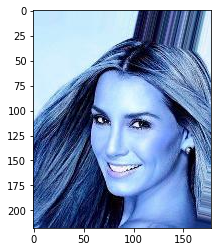

In [ ]:
# plot an image to make sure that everything is in order. Note that pythong plots images in gbr not in rbg.
tensor_img = img_transpose[10]/255
plt.imshow(tensor_img.permute(1, 2, 0))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(41820, 418)
        self.fc2 = nn.Linear(418, 44)
        self.fc3 = nn.Linear(44, 5)
        self.fc4 = nn.Linear(5, 2)

    def forward(self, x):
        x=x
        # (1) Input later "x = x"
        # (2) Hidden conv1 layer
#         x = self.conv1(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # (3) Hidden conv2 layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # (4) Hidden linear layer
        x = x.view(x.size(0),  41820)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [ ]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=41820, out_features=418, bias=True)
  (fc2): Linear(in_features=418, out_features=44, bias=True)
  (fc3): Linear(in_features=44, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=2, bias=True)
)

In [ ]:
answers.astype('float64').values

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.])

In [ ]:
answers_train = torch.from_numpy(answers.astype('float64').values)
answers_train2 = answers_train.long()

img_transpose_train = img_transpose
img_transpose_train.size()

torch.Size([1050, 3, 218, 178])

In [ ]:
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00000000000001)

In [ ]:
for step in range(20):
    models = model(img_transpose_train)
    cross_entropy = cross_entropy_loss(models, answers_train2)
    total_cost = cross_entropy 
    
    print(total_cost)

    optimizer.zero_grad()
    total_cost.backward()
    optimizer.step()

In [ ]:
_ , predicted = torch.max(models.data, 1)
predicted

In [ ]:
_ , predicted = torch.max(models.data, 1)

final = answers_train2.size(0)
correct = (predicted == answers_train2).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / final))
print('- CE : %2.2f,' % (cross_entropy.item()))

# keras Model

In [ ]:
#images_tensor = np.array(imgs)
X = np.array(imgs).astype('float64')/255
y = np.array(answers_train2) #np.array(data_Y["Attractive"].head(1050))
print(y)

[1 0 0 ... 1 1 1]


In [ ]:
# THIS WILL BE USE LATER TO ANALIZE THE CNN
# Tensorboard:
logdir = "/content/"
NAME = "Attractive-{}".format(int(time.time()))
tensorboard_callback = TensorBoard(log_dir=logdir+'logs/{}'.format(NAME))
#tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))  #, strides=None, padding='valid', data_format='channels_first'))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="binary_crossentropy",
             optimizer="adam", 
             metrics=['accuracy'])

model.fit(X, y, batch_size=32,epochs=10, validation_split=0.1, callbacks =[tensorboard_callback])

In [ ]:
dense_layers = [0, 1, 2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size,  dense_layer, int(time.time()))
            tensorboard_callback = TensorBoard(log_dir=logdir+'logs/{}'.format(NAME))
            print(NAME)
            model = Sequential()

            model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2, 2)))  #, strides=None, padding='valid', data_format='channels_first'))

            for l in range(conv_layer-1):
                model.add(Conv2D(conv_layer, (3,3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())
            for l in range(dense_layer):
                model.add(Dense(dense_layer))
                model.add(Activation("relu"))
 
            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            model.compile(loss="binary_crossentropy",
                        optimizer="adam", 
                        metrics=['accuracy'])

            model.fit(X, y, batch_size=32,epochs=10, validation_split=0.1, callbacks =[tensorboard_callback])

In [ ]:
# Load tensorboard:
%tensorboard --logdir /content/